# Setup

In [2]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension


import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# Imports

%load_ext autoreload
import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load Pegasus fine-tuned on cnn_dailymail

model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")

model = model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")

In [5]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices, color='red'):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, color)
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all', color='red'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs, color=color))

In [6]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, ax, label, color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [7]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/orig.txt'
beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/beams_5.csv"
eabs_generation = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/eabs_beams_5_width_5_alpha_5.csv'
all_generation = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/all.csv'

In [8]:
NUM_SEQ=1000
MAX_LEN = 100
MAX_SOURCE_LEN=1024
WIDTH=5

# Entropy of Human Data

In [9]:
human_dataframe = pd.read_csv(orig_wp, sep='\t', names=['context', 'model_text'])
# human_dataframe['model_text'] = human_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))


In [10]:
human_datapoint = human_dataframe.sample(1).iloc[0]
print(human_datapoint.context)
print()
print(print_sample(human_datapoint.context, human_datapoint.model_text))

David Cameron has called on people to 'feel proud to say this is a Christian country', in his annual Easter message. As the election campaign slowed to mark the Easter weekend, the Prime Minister hailed the work of the Church and condemned the persecution of Christians following the massacre in Kenya. Mr Cameron's praise for the Church comes after he criticised bishops for a controversial election letter calling for a 'fresh moral vision of the kind of country we want to be' which was widely seen as an attack on the Coalition's welfare cuts. Scroll down for video. David Cameron feeds orphaned lambs on Dean Lane farm near the village of Chadlington in the Cotswolds. Mr Cameron took a break from the campaign trail to visit the orphaned lambs in the nearby farm in his constituency. Mr Cameron was taken t visit the lambs with farmer Julian Tustian at Dean Lane farm just outside the village of Chadlington. The Archbishop of Canterbury, the Most Rev Justin Welby, has condemned certain welfar

## Compute Average entropy across sequences.

In [11]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

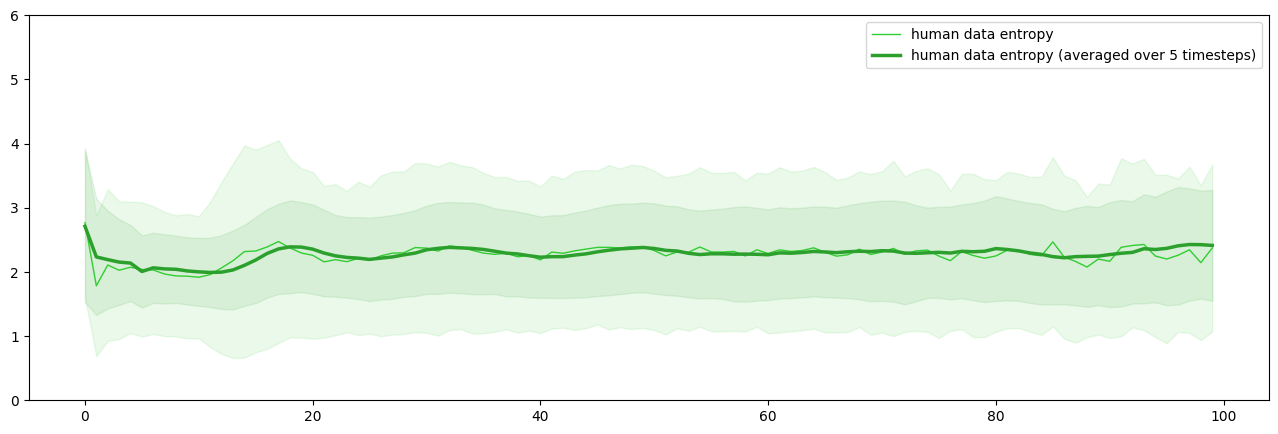

In [37]:
fig, ax = plt.subplots(figsize=(16, 5))
plot_avg_entropies_mean_std(human_entropies, ax, 'human data entropy', color='limegreen')
plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', linewidth=2.5)

## Examples of generation

In [12]:

lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


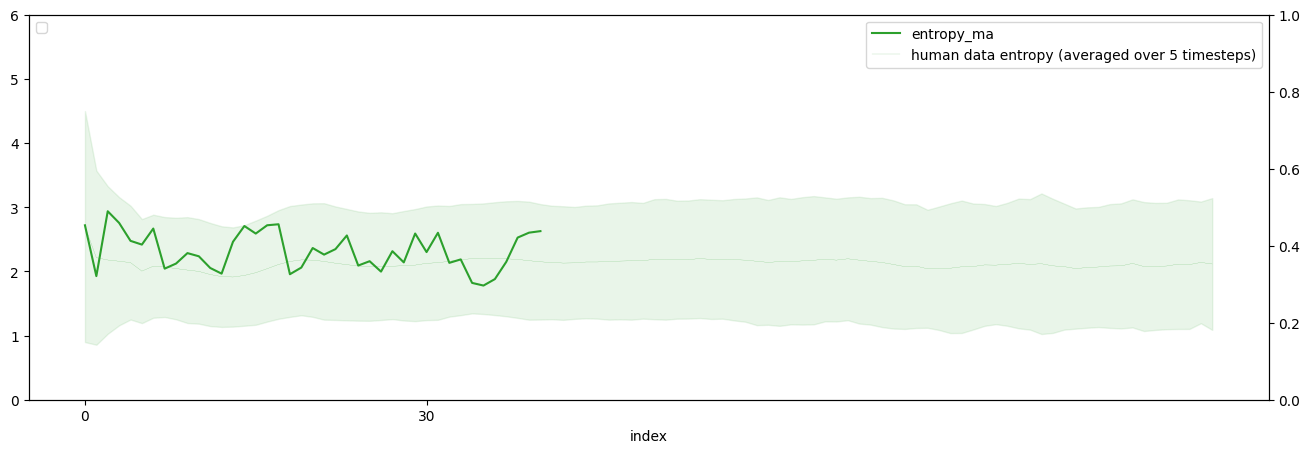

In [13]:
fig, ax = plt.subplots(figsize=(16, 5))
ax2 = ax.twinx()
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2.legend(loc=2)

# lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=ax, color='darkgreen')
lpdh.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, color='tab:green')
ax.set_xticks(np.arange(len(lpdh['index']), step=30))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

# Entropy of Model Data

In [14]:
model_beam_dataframe = pd.read_csv(beam_generation, sep='\t', names=['context', 'model_text'])
model_eabs_dataframe = pd.read_csv(eabs_generation, sep='\t', names=['context', 'model_text'])

## EABS Comparison Example

In [81]:
all_dataframe = pd.read_csv(all_generation, sep='\t', names=['document', 'target', 'beam', 'eabs'])

In [82]:
all_datapoint = all_dataframe.sample(1).iloc[0]
all_datapoint

document    An ancient statue of the wife of China's first...
target      Statue in Wuhan, central China, depicts countr...
beam        Statue depicts Yu The Great, founder of China'...
eabs        Officials in Wuhan, central China, complain st...
Name: 2705, dtype: object

In [83]:
print("Document:")
print(all_datapoint['document'])
print()
print("Target:")
print_sample(all_datapoint['document'], all_datapoint['target'])
print()
print("Beam Summary: ")
print_sample(all_datapoint['document'], all_datapoint['beam'])
print()
print("EABS Summary: ")
print_sample(all_datapoint['document'], all_datapoint['eabs'])
print()

Document:
An ancient statue of the wife of China's first ruler is damaged - after tourists kept rubbing the woman's exposed breast. Officials have complained the bronze sculpture of Yu The Great's wife has been worn down and discolored by sightseers constantly fondling the artwork, reports The People's Daily. The statue, which stands in a gardens in Wuhan, the capital city of central China’s Hubei Province, is to honour Yu The Great, who founded China's first dynasty in 2070 BC. Officials in Wuhan, the capital city of central China’s Hubei Province, have accused tourists of damaging a statue of the country's first leader and his wife by fondling the woman's exposed breast. The sculpture, which has been in place for ten years, depicts Yu The Great, the founder of China's first Xia Dynasty in 2070 BC, meeting his wife. Legend says that Yu and his wife were brought together by a nine-tailed fox that lead them to one another. The bronze tells the story of how the leader met his wife, after

## Examples of various amounts of 3-gram repetition.

In [15]:
human_datapoint = human_dataframe.iloc[100]
# print()
# print(print_sample(human_datapoint.context, human_datapoint.model_text))

human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

In [16]:
print("Context:")
print_sample(human_datapoint.model_text, human_datapoint.context, repeat_type="context")


Context:
(CNN)Anthony Ray Hinton is thankful to be free after nearly 30 years on Alabama's death row for murders he says he didn't commit. And incredulous that it took so long. Hinton, 58, looked up, took in the sunshine and thanked God and his lawyers Friday morning outside the county jail in Birmingham, minutes after taking his first steps as a free man since 1985. He spoke of unjustly losing three decades of his life, under fear of execution, for something he didn't do. "All they had to do was to test the gun, but when you think you're high and mighty and you're above the law, you don't have to answer to nobody," Hinton told reporters. "But I've got news for you -- everybody that played a part in sending me to death row, you will answer to God." Jefferson County Circuit Court Judge Laura Petro had ordered Hinton released after granting the state's motion to dismiss charges against him. Hinton was convicted of murder in the 1985 deaths of two Birmingham-area, fast-food restaurant man

In [21]:
human_datapoint = human_dataframe.sample(1).iloc[0]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]
eabs_sample = model_eabs_dataframe.iloc[human_datapoint_idx]

print("Context:")
print_sample(beam_sample.model_text, human_datapoint.context, repeat_type='context', color='red')



print("Target:")
print_sample(human_datapoint.context, human_datapoint.model_text)
print()
print("Beam Summary: ")
print_sample(human_datapoint.context, beam_sample.model_text)
print()
print("EABS Summary: ")
print_sample(human_datapoint.context, eabs_sample.model_text)
print()

Context:
Security officers were out in force at Los Angeles International Airport on Saturday, allegedly after officials found out ISIS called for attacks on uniformed personnel as part of a possible terror plot. The FBI is investigating and security is being increased at other airports in Southern California because of a 'known threat' to LAX from ISIS, according to a federal law enforcement official. The investigation and security increase started after intercepted communication and other intelligence information led officials to believe that a plot could be under way. Scroll down for video. Security is being increased at airports in Southern California because of a 'known threat' from ISIS at LAX. Officials found out earlier that ISIS called for attacks on uniformed personnel as part of a possible terror plot. The federal law enforcement official did not say whether this was a new threat. The Transportation Security Administration alerted local law enforcement agencies responsible f

<AxesSubplot:xlabel='index'>

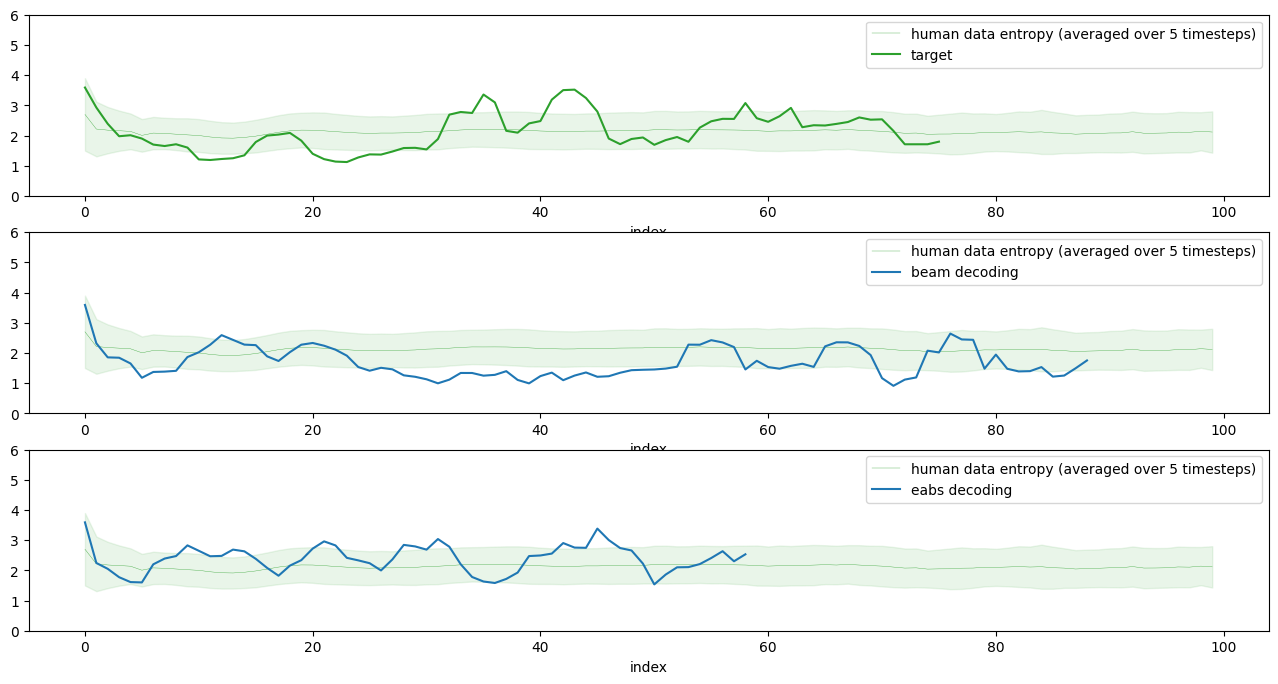

In [18]:

lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

beam_labeled_datapoint = process_datapoint(
    model=model, datapoint=beam_sample, width=WIDTH, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

eabs_labeled_datapoint = process_datapoint(
    model=model, datapoint=eabs_sample, width=WIDTH, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

fig, axs = plt.subplots(3,1, figsize=(16, 8))
plot_avg_entropies_mean_std(human_ma_entropies, axs[0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1, linewidth=0.25)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0], label='target', color='tab:green')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1, linewidth=0.25)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1], label='beam decoding', color='tab:blue')


plot_avg_entropies_mean_std(human_ma_entropies, axs[2], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1, linewidth=0.25)
eabs_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2], label='eabs decoding', color='tab:blue')


# lpdm.plot(x="index", y='dent', ylim=(-4,6), ax=ax)
# ax.set_xticks(np.arange(len(lpdh['index']), step=20))

# ax.set_xlabel("Timestep")
# ax.set_ylabel("Entropy (Averaged over 5 timesteps)")

## Compute Average entropy across timesteps.

### For all model generated data

In [30]:
# Greedy

model_greedy_dataframe = model_beam_dataframe.dropna()
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy', width=WIDTH,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)

<AxesSubplot:title={'center':'Average Entropy vs Timesteps (Model Data w/ Repetition)'}, xlabel='Timesteps', ylabel='Average Entropy'>

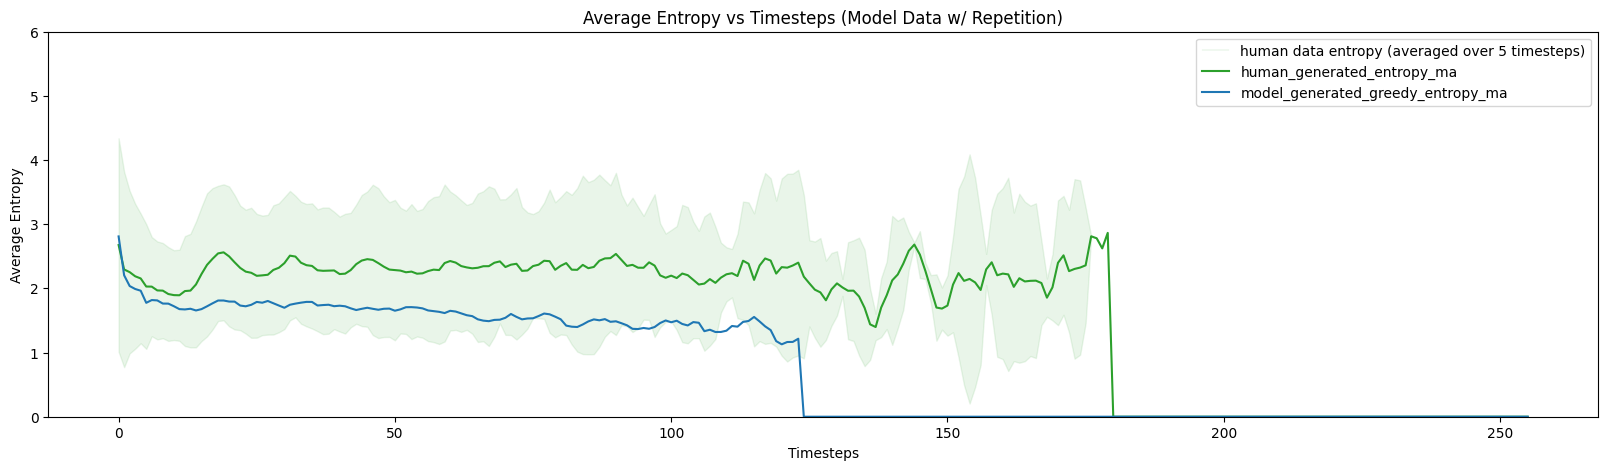

In [31]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd],axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps (Model Data w/ Repetition)', 
    figsize=(20, 5),
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)


# Do errors cascade?

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")